In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from fuzzywuzzy import fuzz
import re
import string

In [2]:
# Simple tokenization function (no NLTK dependency)
def tokenize(text):
    if not isinstance(text, str):
        return []
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    # Split by whitespace
    return [token.strip() for token in text.split() if token.strip()]

# Simple stemming function (for handling plurals without NLTK)
def simple_stem(word):
    """Very basic stemming for English words"""
    if not word or not isinstance(word, str):
        return word
        
    word = word.lower()
    
    # Common plural endings
    if len(word) > 3:
        if word.endswith('ies') and len(word) > 4:
            return word[:-3] + 'y'  # universities -> university
        elif word.endswith('es') and len(word) > 3:
            return word[:-2]  # classes -> class
        elif word.endswith('s') and not word.endswith('ss'):
            return word[:-1]  # students -> student
    
    return word

# Text preprocessing function (NLTK-free)
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
        
    # Tokenize
    tokens = tokenize(text)
    
    # Apply simple stemming
    stemmed_tokens = [simple_stem(token) for token in tokens]
    
    # Rejoin tokens
    return ' '.join(stemmed_tokens)

In [3]:
# # Load and clean data
# file_path = 'university_faq.xlsx'
# df = pd.read_excel(file_path)
# df.columns = df.columns.str.strip()

# # Preprocess the dataset
# df['Processed_Question'] = df['Question'].apply(preprocess_text)
# df['Processed_Keyword'] = df['Keyword'].apply(preprocess_text)

# # Build domain dictionary for spelling correction
# domain_dictionary = set()
# for text in df['Question'].tolist() + df['Keyword'].tolist():
#     if isinstance(text, str):
#         tokens = tokenize(text)
#         domain_dictionary.update(tokens)

# # Display first few rows of the processed dataset
# df.head()

In [4]:
# def populate_domain_entities(df):
#     """Populate domain entities from dataset using keyword analysis"""
#     buildings = set()
#     departments = set()
#     services = set()
    
#     # Define category indicators
#     building_keywords = {'building', 'block', 'campus', 'location', 'center', 'lab', 'laboratory'}
#     department_keywords = {'department', 'dept', 'cse', 'muj', 'faculty'}
#     service_keywords = {'admission', 'programs', 'courses', 'services', 'eligibility', 'registration'}
    
#     for _, row in df.iterrows():
#         # Split keywords and clean them
#         keywords = [k.strip().lower() for k in str(row['Keyword']).split(',')]
#         question = str(row['Question']).lower()
        
#         # Process each keyword
#         for keyword in keywords:
#             # Check for buildings
#             if any(bk in keyword or bk in question for bk in building_keywords):
#                 buildings.add(keyword)
            
#             # Check for departments
#             if any(dk in keyword or dk in question for dk in department_keywords):
#                 departments.add(keyword)
            
#             # Check for services
#             if any(sk in keyword or sk in question for sk in service_keywords):
#                 services.add(keyword)
        
#         # Extract specific entities from questions
#         # Look for department names (e.g., "CSE")
#         dept_matches = re.findall(r'\b[A-Za-z]{2,5}\b department', question)
#         departments.update([d.split()[0] for d in dept_matches])
        
#         # Look for location indicators
#         if 'where is' in question or 'located' in question:
#             buildings.update([k for k in keywords if 'location' in k or 'building' in k])
    
#     # Clean up the sets
#     buildings = {b for b in buildings if len(b) > 2}  # Remove very short terms
#     departments = {d for d in departments if len(d) > 2}
#     services = {s for s in services if len(s) > 2}
    
#     global DOMAIN_ENTITIES
#     DOMAIN_ENTITIES = {
#         'buildings': list(buildings),
#         'departments': list(departments),
#         'services': list(services)
#     }
    
#     # Print extracted entities for verification
#     print("Extracted Entities:")
#     print("Buildings:", sorted(list(buildings)))
#     print("Departments:", sorted(list(departments)))
#     print("Services:", sorted(list(services)))

# # Add this after your data loading code
# # First, print the shape of your dataframe
# print(f"DataFrame shape: {df.shape}")

# # Then populate entities
# populate_domain_entities(df)

In [5]:
# First, import required libraries
import pandas as pd
import re

# Load and clean data
file_path = 'university_faq.xlsx'
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# # Define tokenize function if not already defined
# def tokenize(text):
#     if not isinstance(text, str):
#         return []
#     # Convert to lowercase and remove punctuation
#     text = text.lower()
#     text = re.sub(r'[^\w\s]', ' ', text)
#     # Split by whitespace
#     return [token.strip() for token in text.split() if token.strip()]

# Define preprocess_text function if not already defined
# def preprocess_text(text):
#     if not isinstance(text, str):
#         return ""
#     # Tokenize
#     tokens = tokenize(text)
#     # Rejoin tokens
#     return ' '.join(tokens)

# Preprocess the dataset
df['Processed_Question'] = df['Question'].apply(preprocess_text)
df['Processed_Keyword'] = df['Keyword'].apply(preprocess_text)

# Build domain dictionary for spelling correction
domain_dictionary = set()
for text in df['Question'].tolist() + df['Keyword'].tolist():
    if isinstance(text, str):
        tokens = tokenize(text)
        domain_dictionary.update(tokens)

def populate_domain_entities(df):
    """Populate domain entities from dataset using keyword analysis"""
    buildings = set()
    departments = set()
    services = set()
    
    # Define category indicators
    building_keywords = {'building', 'block', 'campus', 'location', 'center', 'lab', 'laboratory'}
    department_keywords = {'department', 'dept', 'cse', 'muj', 'faculty'}
    service_keywords = {'admission', 'programs', 'courses', 'services', 'eligibility', 'registration'}
    
    for _, row in df.iterrows():
        # Split keywords and clean them
        keywords = [k.strip().lower() for k in str(row['Keyword']).split(',')]
        question = str(row['Question']).lower()
        
        # Process each keyword
        for keyword in keywords:
            # Check for buildings
            if any(bk in keyword or bk in question for bk in building_keywords):
                buildings.add(keyword)
            
            # Check for departments
            if any(dk in keyword or dk in question for dk in department_keywords):
                departments.add(keyword)
            
            # Check for services
            if any(sk in keyword or sk in question for sk in service_keywords):
                services.add(keyword)
        
        # Extract specific entities from questions
        # Look for department names (e.g., "CSE")
        dept_matches = re.findall(r'\b[A-Za-z]{2,5}\b department', question)
        departments.update([d.split()[0] for d in dept_matches])
        
        # Look for location indicators
        if 'where is' in question or 'located' in question:
            buildings.update([k for k in keywords if 'location' in k or 'building' in k])
    
    # Clean up the sets
    buildings = {b for b in buildings if len(b) > 2}  # Remove very short terms
    departments = {d for d in departments if len(d) > 2}
    services = {s for s in services if len(s) > 2}
    
    global DOMAIN_ENTITIES
    DOMAIN_ENTITIES = {
        'buildings': list(buildings),
        'departments': list(departments),
        'services': list(services)
    }
    
    # Print extracted entities for verification
    print("Extracted Entities:")
    print("Buildings:", sorted(list(buildings)))
    print("Departments:", sorted(list(departments)))
    print("Services:", sorted(list(services)))

# Display first few rows and shape of the dataset
print(f"DataFrame shape: {df.shape}")
print("\nFirst few rows of the dataset:")
print(df.head())

# Then populate entities
populate_domain_entities(df)

DataFrame shape: (493, 5)

First few rows of the dataset:
                                            Question  \
0  What programs does the CSE department at MUJ o...   
1  What are the eligibility criteria for admissio...   
2  What is the duration of the B.Tech CSE program...   
3  Where is the CSE department located on the MUJ...   
4      Who is the head of the CSE department at MUJ?   

                                             Keyword  \
0  programs, courses, undergraduate, postgraduate...   
1  eligibility, admission, criteria, entrance exa...   
2  duration, course length, years, semesters, cur...   
3       department location, building, campus, block   
4              hod, faculty, administration, contact   

                                              Answer  \
0                                             xxxyyy   
1  The answer to your question 'What are the elig...   
2  The answer to your question 'What is the durat...   
3  The answer to your question 'Where is the

In [6]:
# Function to generate variations
def generate_variations(text):
    if not isinstance(text, str):
        return [text] if text else [""]
        
    variations = [text]
    
    # Simple plural/singular handling
    words = text.split()
    for i, word in enumerate(words):
        # Try both stemmed and original forms
        stemmed = simple_stem(word)
        if stemmed != word:
            new_words = words.copy()
            new_words[i] = stemmed
            variations.append(' '.join(new_words))
    
    # Add common misspellings for university terms
    common_misspellings = {
        'university': ['univercity', 'univarsity', 'uni'],
        'admission': ['admision', 'admisssion'],
        'scholarship': ['scolarship', 'scholarshipp'],
        'registration': ['registraton', 'registeration', 'signup'],
        'course': ['cours', 'coarse', 'class'],
        'professor': ['professer', 'proffesor', 'prof'],
        'semester': ['semister', 'semestre', 'term'],
        'tuition': ['tution', 'tuishon', 'fees'],
        'degree': ['degre', 'diploma', 'qualification'],
        'dormitory': ['dorm', 'housing', 'residence'],
        'major': ['specialization', 'concentration', 'field'],
        'credit': ['cred', 'unit', 'point'],
        'exam': ['examination', 'test', 'assessment'],
        'financial': ['fiscal', 'money', 'monetary'],
        'transfer': ['xfer', 'switch', 'change'],
        'deadline': ['due date', 'cutoff', 'timeframe'],
        'application': ['app', 'apply', 'submission'],
        'schedule': ['timetable', 'calendar', 'agenda']
    }
    
    for word, misspellings in common_misspellings.items():
        if word in text:
            for misspelling in misspellings:
                variations.append(text.replace(word, misspelling))
                
    return variations

# Uncommenting this section will expand your dataset with variations

# Option to expand dataset with variations
expanded_questions = []
expanded_keywords = []
expanded_answers = []
expanded_indices = []

for idx, row in df.iterrows():
    question_variations = generate_variations(row['Processed_Question'])
    keyword_variations = generate_variations(row['Processed_Keyword'])
    
    for q_var in question_variations:
        for k_var in keyword_variations:
            expanded_questions.append(q_var)
            expanded_keywords.append(k_var)
            expanded_answers.append(row['Answer'])
            expanded_indices.append(idx)  # Keep track of original index

expanded_df = pd.DataFrame({
    'Processed_Question': expanded_questions,
    'Processed_Keyword': expanded_keywords,
    'Answer': expanded_answers,
    'Original_Index': expanded_indices
})

# Use expanded dataset or original
# use_df = expanded_df
use_df = df  # Comment this out if using expanded dataset


In [7]:
# Add after your existing preprocessing functions (like tokenize, simple_stem, etc.)
# New cell for entity handling and validation

# Domain-specific dictionary
DOMAIN_ENTITIES = {
    'buildings': ['ab1', 'library', 'cafeteria'],  # Add your actual building names
    'departments': ['cs', 'mechanical', 'electrical'],  # Add your departments
    'services': ['admission', 'registration', 'library']  # Add your services
}

def extract_key_terms(text):
    """Extract important terms from text"""
    if not isinstance(text, str):
        return []
    
    # Convert to lowercase and tokenize
    terms = tokenize(text)
    
    # Remove common words (you can expand this list)
    common_words = {'what', 'where', 'when', 'how', 'is', 'are', 'the', 'a', 'an', 'in', 'at', 'to'}
    terms = [term for term in terms if term not in common_words]
    
    return terms

def validate_entities(question_terms, database_terms):
    """Check if important entities in question exist in our knowledge base"""
    # Convert both to sets of strings for comparison
    question_set = set(str(term).lower() for term in question_terms)
    database_set = set(str(term).lower() for term in database_terms)
    
    # Find matching and unmatched terms
    matched = question_set & database_set
    unmatched = question_set - database_set
    
    # Calculate match ratio
    match_ratio = len(matched) / len(question_set) if question_set else 0
    
    return match_ratio, unmatched

def calculate_adjusted_confidence(base_confidence, question, matched_answer):
    """Calculate adjusted confidence score based on entity matching"""
    # Extract key terms
    question_terms = extract_key_terms(question)
    database_terms = extract_key_terms(matched_answer)
    
    # Calculate match ratio
    match_ratio, unmatched_terms = validate_entities(question_terms, database_terms)
    
    # If critical terms are missing, reduce confidence
    if unmatched_terms:
        # The more unmatched terms, the lower the confidence
        penalty = len(unmatched_terms) * 0.3
        base_confidence = max(0, base_confidence - penalty)
    
    # Adjust final confidence
    final_confidence = base_confidence * match_ratio
    
    return final_confidence, unmatched_terms

In [8]:
# Initialize TF-IDF vectorizers with improved parameters
question_vectorizer = TfidfVectorizer(
    min_df=1, max_df=0.9,
    ngram_range=(1, 2),  # Include bigrams
    stop_words='english'
)

keyword_vectorizer = TfidfVectorizer(
    min_df=1, max_df=0.9,
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit vectorizers
question_vectors = question_vectorizer.fit_transform(df['Processed_Question'])
keyword_vectors = keyword_vectorizer.fit_transform(df['Processed_Keyword'])

In [9]:
def correct_spelling(text):
    if not isinstance(text, str):
        return str(text) if text else ""
        
    try:
        corrected = str(TextBlob(text).correct())
        
        # Protect domain-specific terms from "correction"
        words = text.lower().split()
        corrected_words = corrected.lower().split()
        
        # Only replace words if length matches
        if len(words) == len(corrected_words):
            for i, (orig_word, corr_word) in enumerate(zip(words, corrected_words)):
                if orig_word in domain_dictionary and orig_word != corr_word:
                    corrected_words[i] = orig_word
            
            return ' '.join(corrected_words)
        return corrected
    except Exception as e:
        print(f"Spelling correction error: {e}")
        return text

# Matching function
# def match_input(processed_input):
#     try:
#         # Vector matching
#         user_question_vector = question_vectorizer.transform([processed_input])
#         question_similarities = cosine_similarity(user_question_vector, question_vectors)
#         question_match_idx = question_similarities.argmax()
#         question_score = question_similarities[0][question_match_idx]
        
#         user_keyword_vector = keyword_vectorizer.transform([processed_input])
#         keyword_similarities = cosine_similarity(user_keyword_vector, keyword_vectors)
#         keyword_match_idx = keyword_similarities.argmax()
#         keyword_score = keyword_similarities[0][keyword_match_idx]
        
#         # Determine best match
#         if keyword_score > question_score:
#             return {
#                 'answer': df.iloc[keyword_match_idx]['Answer'],
#                 'confidence': keyword_score,
#                 'match_type': 'keyword'
#             }
#         else:
#             return {
#                 'answer': df.iloc[question_match_idx]['Answer'],
#                 'confidence': question_score,
#                 'match_type': 'question'
#             }
#     except Exception as e:
#         print(f"Vector matching error: {e}")
#         return {'answer': "", 'confidence': 0.0, 'match_type': 'error'}

# Replace your existing match_input function with this enhanced version
def match_input(processed_input):
    try:
        # Vector matching
        user_question_vector = question_vectorizer.transform([processed_input])
        question_similarities = cosine_similarity(user_question_vector, question_vectors)
        question_match_idx = question_similarities.argmax()
        question_score = question_similarities[0][question_match_idx]
        
        user_keyword_vector = keyword_vectorizer.transform([processed_input])
        keyword_similarities = cosine_similarity(user_keyword_vector, keyword_vectors)
        keyword_match_idx = keyword_similarities.argmax()
        keyword_score = keyword_similarities[0][keyword_match_idx]
        
        # Determine best match and calculate adjusted confidence
        if keyword_score > question_score:
            final_confidence, unmatched = calculate_adjusted_confidence(
                keyword_score,
                processed_input,
                df.iloc[keyword_match_idx]['Keyword']
            )
            return {
                'answer': df.iloc[keyword_match_idx]['Answer'],
                'confidence': final_confidence,
                'match_type': 'keyword',
                'unmatched_terms': unmatched
            }
        else:
            final_confidence, unmatched = calculate_adjusted_confidence(
                question_score,
                processed_input,
                df.iloc[question_match_idx]['Question']
            )
            return {
                'answer': df.iloc[question_match_idx]['Answer'],
                'confidence': final_confidence,
                'match_type': 'question',
                'unmatched_terms': unmatched
            }
    except Exception as e:
        print(f"Vector matching error: {e}")
        return {'answer': "", 'confidence': 0.0, 'match_type': 'error', 'unmatched_terms': set()}

# Fuzzy matching as fallback
def fuzzy_match(user_input):
    max_score = 0
    best_idx = -1
    
    # Try both question and keyword fuzzy matching
    for idx, row in df.iterrows():
        try:
            question = row.get('Question', '')
            keyword = row.get('Keyword', '')
            
            if isinstance(question, str) and isinstance(keyword, str):
                # Use token_sort_ratio for better handling of word order differences
                q_score = fuzz.token_sort_ratio(user_input.lower(), question.lower())
                k_score = fuzz.token_sort_ratio(user_input.lower(), keyword.lower())
                
                # Also try partial ratio for substring matching
                q_partial = fuzz.partial_ratio(user_input.lower(), question.lower())
                k_partial = fuzz.partial_ratio(user_input.lower(), keyword.lower())
                
                # Take the best score
                max_row_score = max(q_score, k_score, q_partial, k_partial) / 100
                
                if max_row_score > max_score:
                    max_score = max_row_score
                    best_idx = idx
        except Exception as e:
            print(f"Fuzzy matching error on row {idx}: {e}")
    
    if best_idx >= 0:
        return {
            'answer': df.iloc[best_idx]['Answer'],
            'confidence': max_score,
            'match_type': 'fuzzy'
        }
    return {'answer': "", 'confidence': 0.0, 'match_type': 'fuzzy_failed'}

In [10]:
# Enhanced response function
def get_response(user_input, confidence_threshold=0.5):
    if not isinstance(user_input, str) or not user_input.strip():
        return "I need a question to help you.", 0.0
    
    # Step 1: Preprocess input
    processed_input = preprocess_text(user_input)
    
    # Step 2: Try with original preprocessed input
    result = match_input(processed_input)
    if result['confidence'] >= confidence_threshold:
        return result['answer'], result['confidence']
    
    # Step 3: Try spelling correction if confidence is low
    corrected_input = correct_spelling(user_input)
    if corrected_input.lower() != user_input.lower():
        processed_corrected = preprocess_text(corrected_input)
        corrected_result = match_input(processed_corrected)
        if corrected_result['confidence'] > result['confidence']:
            return corrected_result['answer'], corrected_result['confidence'], corrected_input
    
    # Step 4: Try fuzzy matching as another fallback
    fuzzy_result = fuzzy_match(user_input)
    if fuzzy_result['confidence'] > result['confidence']:
        return fuzzy_result['answer'], fuzzy_result['confidence']
    
    # Return best result found, even if confidence is low
    if result['confidence'] > 0.15:  # Minimum threshold
        return result['answer'], result['confidence']
    
    return "I'm not sure I understand. Could you rephrase your question?", 0.0

# Example usage
# Update your existing chatbot_response function
def chatbot_response(user_input):
    try:
        result = get_response(user_input)
        
        # Unpack response based on length
        if len(result) == 3:
            answer, confidence, corrected = result
            
            # Check for unmatched terms in the response
            if hasattr(result, 'unmatched_terms') and result.unmatched_terms:
                return f"I notice you asked about '{', '.join(result.unmatched_terms)}' which I don't have information about. Could you please clarify or ask about a different topic?"
            
            # Your existing confidence-based responses
            if confidence > 0.6:
                return f"Did you mean: '{corrected}'?\n\n{answer}"
            elif confidence > 0.3:
                return f"Did you mean: '{corrected}'?\n\nI think you're asking about: {answer}"
            else:
                return f"Did you mean: '{corrected}'?\n\nI'm not entirely sure, but this might help: {answer}"
        else:
            answer, confidence = result
            
            # Check for unmatched terms
            if hasattr(result, 'unmatched_terms') and result.unmatched_terms:
                return f"I notice you asked about '{', '.join(result.unmatched_terms)}' which I don't have information about. Could you please clarify or ask about a different topic?"
            
            # Your existing confidence-based responses
            if confidence > 0.6:
                return answer
            elif confidence > 0.3:
                return f"I think you're asking about: {answer}"
            else:
                return f"I'm not entirely sure, but this might help: {answer}"
    except Exception as e:
        return f"Sorry, I encountered an error processing your question. Please try again with different wording."

In [11]:
# Main chatbot loop
print("University FAQ Chatbot (type 'exit' to quit)")
while True:
    user_input = input("Ask me something: ").strip()
    if user_input.lower() == 'exit':
        print("Goodbye!")
        break
    response = chatbot_response(user_input)
    print(f"Chatbot: {response}\n")

University FAQ Chatbot (type 'exit' to quit)


Ask me something:  where is dome?


Chatbot: front of ab2



Ask me something:  dome


Chatbot: front of ab2



Ask me something:  where is ab1


Chatbot: The answer to your question 'Where is the CSE department located on the MUJ campus?' is currently unavailable. Please refer to official sources for accurate information.



Ask me something:  exit


Goodbye!


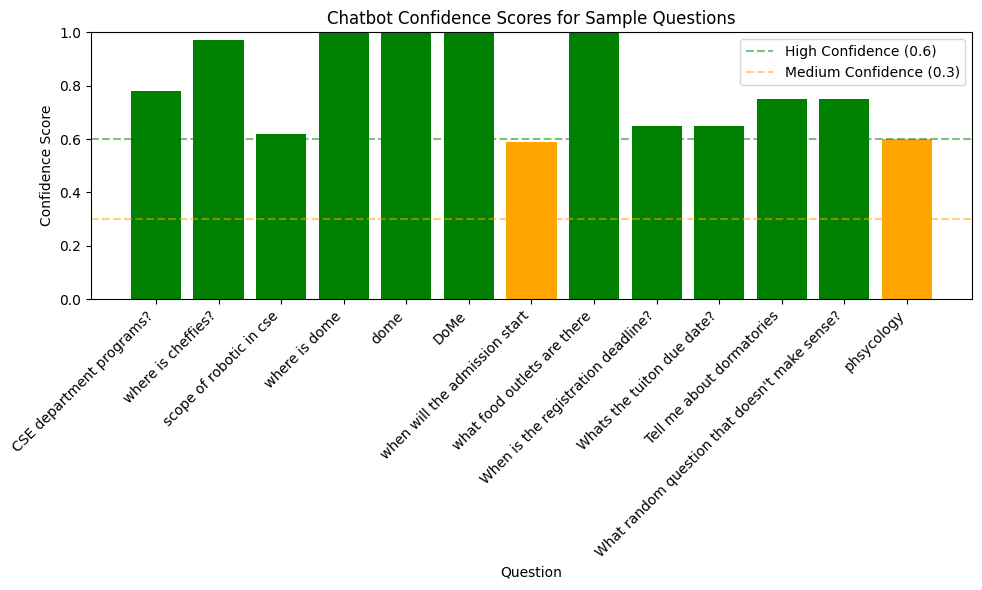

,question,confidence,response
0,CSE department programs?,0.78,The answer to your question 'Who is the head o...
1,where is cheffies?,0.97,in SAC
2,scope of robotic in cse,0.62,The answer to your question 'Are there any opp...
3,where is dome,1.00,front of ab2
4,dome,1.00,front of ab2
5,DoMe,1.00,front of ab2
6,when will the admission start,0.59,I think you're asking about: The answer to you...
7,what food outlets are there,1.00,"old mess, sac, ab2"
8,When is the registration deadline?,0.65,in SAC
9,Whats the tuiton due date?,0.65,The answer to your question 'What is the durat...


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def test_and_visualize_questions(questions):
    results = []
    for q in questions:
        result = get_response(q)
        conf = result[1] if len(result) >= 2 else 0
        results.append({
            'question': q,
            'confidence': conf,
            'response': chatbot_response(q)
        })
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    
    confidences = [r['confidence'] for r in results]
    questions = [r['question'] for r in results]
    
    bar_colors = ['green' if c > 0.6 else 'orange' if c > 0.3 else 'red' for c in confidences]
    
    bars = ax.bar(range(len(questions)), confidences, color=bar_colors)
    
    ax.set_xlabel('Question')
    ax.set_ylabel('Confidence Score')
    ax.set_title('Chatbot Confidence Scores for Sample Questions')
    ax.set_xticks(range(len(questions)))
    ax.set_xticklabels(questions, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    
    # Add threshold lines
    ax.axhline(y=0.6, color='green', linestyle='--', alpha=0.5, label='High Confidence (0.6)')
    ax.axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, label='Medium Confidence (0.3)')
    
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Display detailed results in a table
    return pd.DataFrame(results)

# Test with sample questions
sample_questions = [
    "CSE department programs?",
    "where is cheffies?",
    # "What kind of support does MUJ provide for CSE students interested in robotics research?",
    "scope of robotic in cse",
    "where is dome",
    "dome",
    "DoMe",
    "when will the admission start",
    "what food outlets are there",
    "When is the registration deadline?",
    "Whats the tuiton due date?",  # Intentional typo
    "Tell me about dormatories",  # Intentional typo
    "What random question that doesn't make sense?",
    "phsycology"
]

results_df = test_and_visualize_questions(sample_questions)
results_df